# Non-Markovian Gaussian Sequence Model

We We consider a non-Markovian Gaussian sequence model (NM-GSM) of the form

$$
\begin{aligned}
    f_t(x_t \vert x_{t-1}) &= \mathcal{N}(x_t \vert \phi x_{t-1}, q),\\
    g_t(y_t \vert x_{1:t}) &= \mathcal{N}\left(y_t, \sum_{k=1}^t \beta^{t-k} x_k, r\right)
\end{aligned}
$$

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from jsmc.datagen import non_markovian_gsm as nmgsm

In [2]:
plt.rcParams["figure.figsize"] = [6.4, 4.0]
%config InlineBackend.figure_format = "retina"

In [3]:
num_steps = 100
n_sims = 5
key = jax.random.PRNGKey(314)
keys = jax.random.split(key, n_sims)

vmap_nmgsm = jax.vmap(nmgsm.non_markovian_gsm, (0, None, None))

In [4]:
# Parameters presented in Example 1.2.1
params = nmgsm.ModelParameters(phi=0.9, q=1.0, beta=0.5, r=1)
simulations = vmap_nmgsm(keys, params, num_steps)

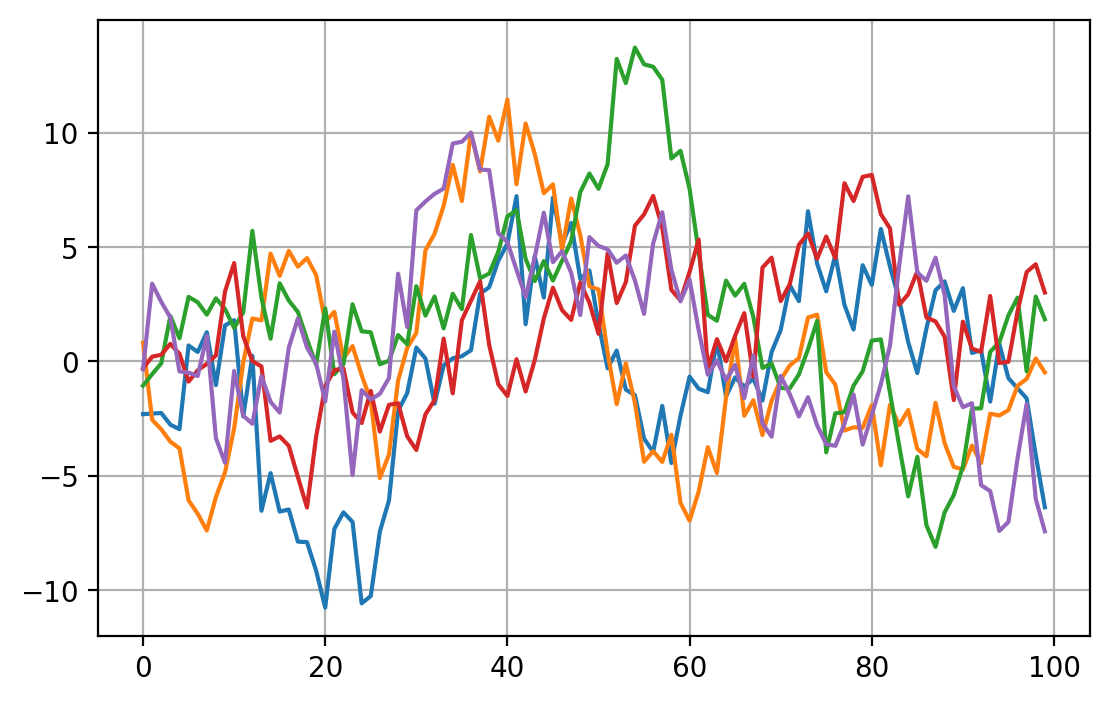

In [5]:
plt.plot(simulations.y.T)
plt.grid()

## Evaluating multiple $\beta$ configurations

As mentioned in the paper, 
> We can adjust the strength of the dependence on previous latent variables in the observations $y_t$, through the parameter $\beta\in[0,1]$. If we set $\beta=0$ we obtain a linear Gaussian state-space model (SSM) [...]. On the other hand, if we let $\beta=1$, this signifies that $x_k$ for $k < t$ has equally strong effect on $y_t$ as does $x_t$.

In [6]:
@partial(jax.vmap, in_axes=(None, 0, None, None))
def eval_nmgsm_beta(key, beta, params, num_steps):
    params = nmgsm.ModelParameters(phi=0.9, q=1.0, beta=beta, r=1)
    simulations = vmap_nmgsm(keys, params, num_steps)
    return simulations

In [7]:
beta_vals = jnp.array([0.0, 0.5, 0.8, 1.0])
simulations = eval_nmgsm_beta(keys, beta_vals, params, num_steps)

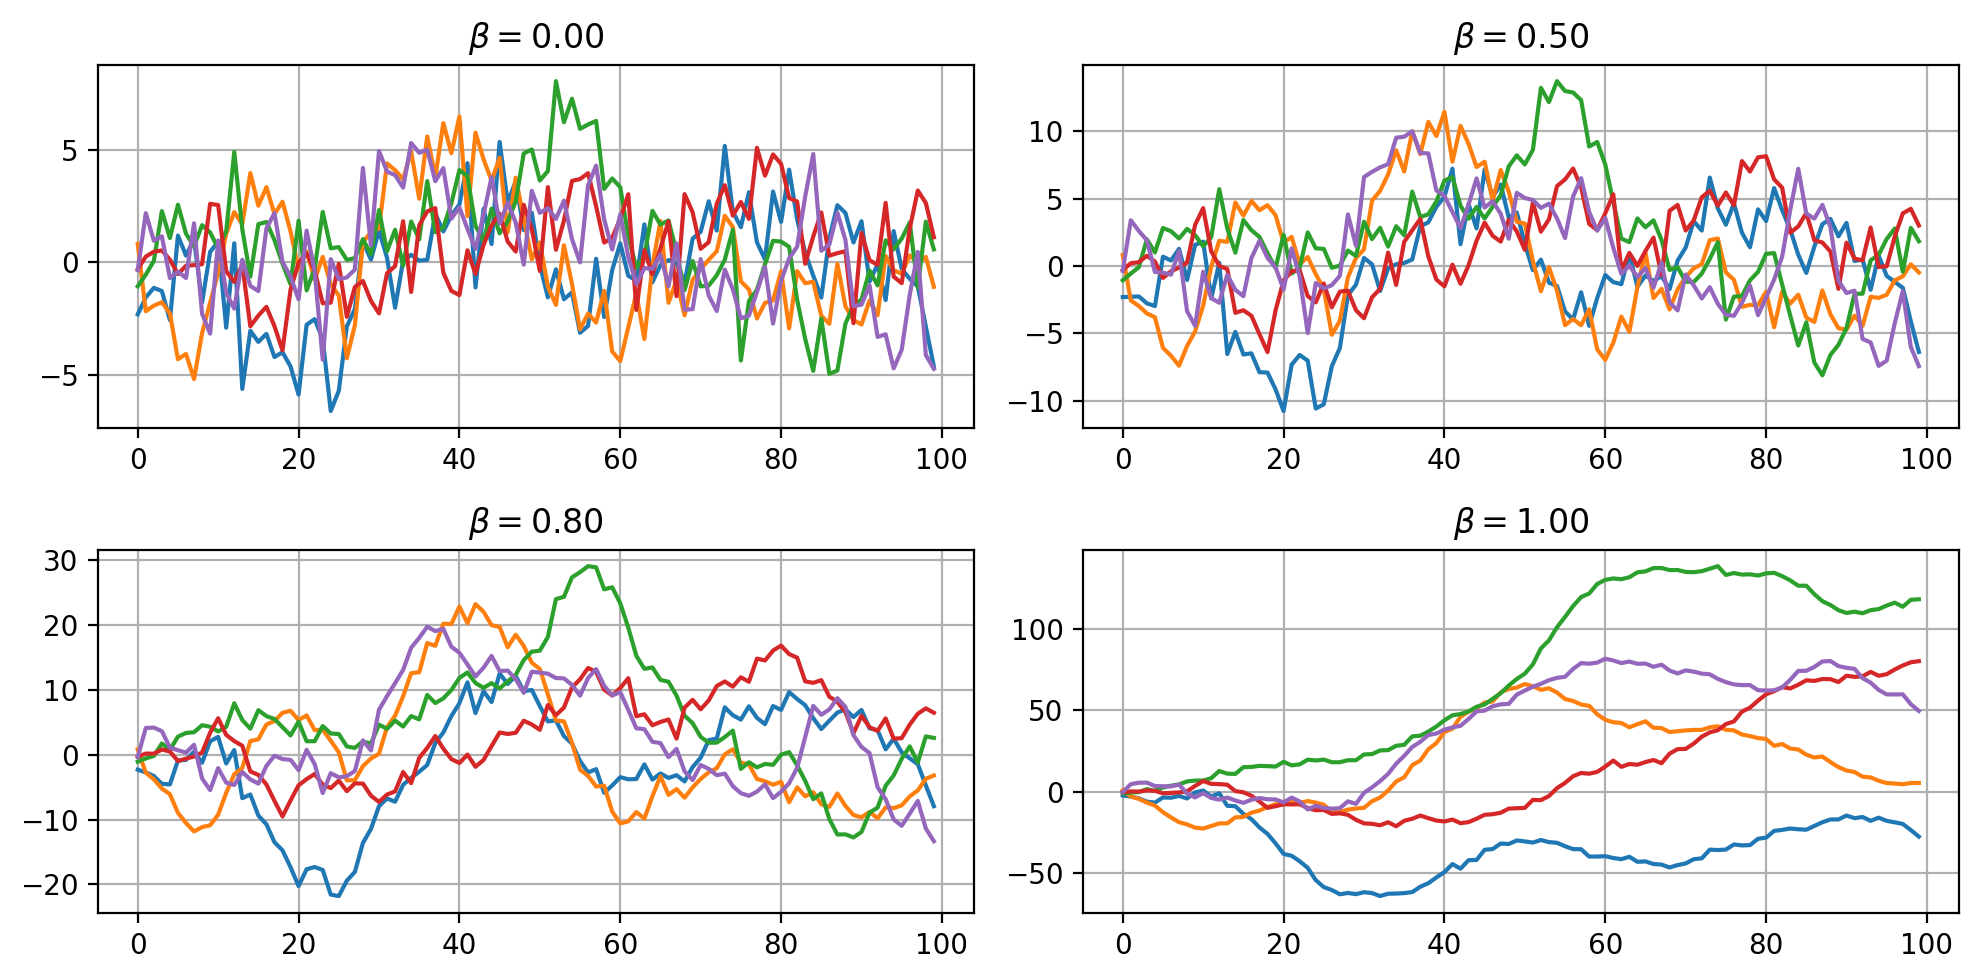

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs = axs.ravel()

for ax, beta, simul in zip(axs, beta_vals, simulations.y):
    ax.plot(simul.T)
    ax.set_title(r"$\beta=$" f"{beta:0.2f}")
    ax.grid()
plt.tight_layout()